# Init

In [14]:

import os
import pickle
import pandas as pd
# from postProcessingFunctions import processOutputs, replaceValueInFile, parallelizeFunction, genExtList
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gumbel_r, gumbel_l
from scipy.stats import genextreme

import re

import numpy as np

from IPython.display import display, Markdown

import moorpy as mp
import copy

from moorpy_functions import genMoorpySys2


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [15]:
def calcJensenWakeVel( vel, x_d, turbDia, constWindDf, k = 0.04, rhoAir = 1.225):
    rotThrust = np.interp(vel, np.round(constWindDf['Wind1VelX_[m/s]'], 3), constWindDf['RtFldFxh_[kN]']*1000, left=0, right=0) 
    ct = rotThrust/(0.5 * rhoAir * (np.pi*(turbDia)**2/4) * vel**2)
    redVel = (1 - (1 - np.sqrt(1 - ct))/(1 + 2*k * x_d)**2) * vel
    return redVel


def calcFrandsenTI( I0, vel, x_d, turbDia, constWindDf, rhoAir = 1.225):
        rotThrust = np.interp(vel, np.round(constWindDf['Wind1VelX_[m/s]'], 3), constWindDf['RtFldFxh_[kN]']*1000, left=0, right=0) 
        ct = rotThrust/(0.5 * rhoAir * (np.pi*(turbDia)**2/4) * vel**2)
        I_eff = np.sqrt(1.2 * ct/(x_d)**2 + I0**2)
        return I_eff


def getDamDict(df, fatBinDf): 
    df_cpy = df.copy()
    df_merged = df_cpy.merge(fatBinDf, on='bin', how='left')
   
    if len(df_merged) != len(df_cpy) or len(df_merged) != len(fatBinDf):
        raise ValueError("Merge resulted in dropped rows due to unmatched 'bin' values.")
    
    damDict = {}
    
    for col in df_merged.columns:
        if 'ANCH' in col or 'FAIR' in col:
            damDict[col] = np.sum(df_merged[col] * df_merged["prob"])
    return damDict


def calcDamage(df_path, fatBinDf):
    df = pd.read_parquet(df_path)
    df = df.reset_index()
    df['bin'] = df['index'].str.extract(r'.*_(\d+)_.*').astype(int)  
    df.set_index('index', inplace=True)
    damDict = getDamDict(df, fatBinDf)
    return damDict
    
    
      

In [16]:
resultsFol = Path(r'..\results')
dataFol = r'..\data'

In [17]:
turbDia = 240
rhoAir = 1.225
constWindDf = pd.read_excel(os.path.join(dataFol, r"IEA-15MW-240-RWT_steady_state_results.xlsx"))
x_d = 9.6

Text(0, 0.5, 'Thrust Coefficient')

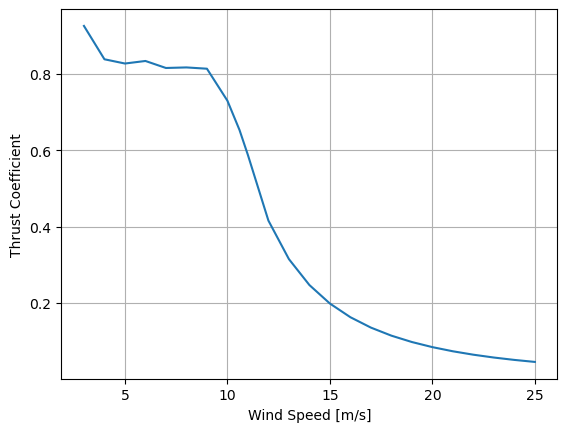

In [18]:
#constant wind data

constWindDf['c_T'] = constWindDf['RtFldFxh_[kN]']*1000/(0.5 * rhoAir * (np.pi*(turbDia)**2/4) * constWindDf['Wind1VelX_[m/s]'].values**2)

plt.plot(constWindDf['Wind1VelX_[m/s]'], constWindDf['c_T'])
plt.grid(True)
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Thrust Coefficient')

In [19]:
envDict = pd.read_excel(os.path.join(dataFol, r"envCond.xlsx"), sheet_name=None, skiprows=[1])
fatBinDf = envDict['fatigue']

# df['bin'] = df['index'].str.extract(r'_.*_(\d+)_.').astype(int)
# df = df.sort_values(by='bin')
# df = df.merge(fatBinDf, on='bin', how='left')

#checked the impact of reducing the chain size directly - without actually adjusting the chain properties

orientList = np.arange(-60, 60, 10)

fat_damageDict = {f'C142_{orient}': os.path.join(resultsFol, f"P200_C142_L1430_clump40_fat_{orient}_damage.parquet") for orient in orientList}
fat_simDict = {f'C142_{orient}': os.path.join(resultsFol, f"P200_C142_L1430_clump40_fat_{orient}.parquet") for orient in orientList}

LineMap = { 'ANCHTEN1' : 'Line 1 : Btm Chain - Btm',
            'FAIRTEN1' : 'Line 1 : Btm Chain - Top',
            'ANCHTEN6' : 'Line 1 : Top Chain - Btm',
            'FAIRTEN6' : 'Line 1 : Top Chain - Top',

            'ANCHTEN7' : 'Line 2 : Btm Chain - Btm',
            'FAIRTEN7' : 'Line 2 : Btm Chain - Top',
            'ANCHTEN12' : 'Line 2 : Top Chain - Btm',
            'FAIRTEN12' : 'Line 2 : Top Chain - Top',

            'ANCHTEN13' : 'Line 3 : Btm Chain - Btm',
            'FAIRTEN13' : 'Line 3 : Btm Chain - Top',
            'ANCHTEN18' : 'Line 3 : Top Chain - Btm',
            'FAIRTEN18' : 'Line 3 : Top Chain - Top',
            }


## Jensen model

KeyError: '9.6D_deficit'

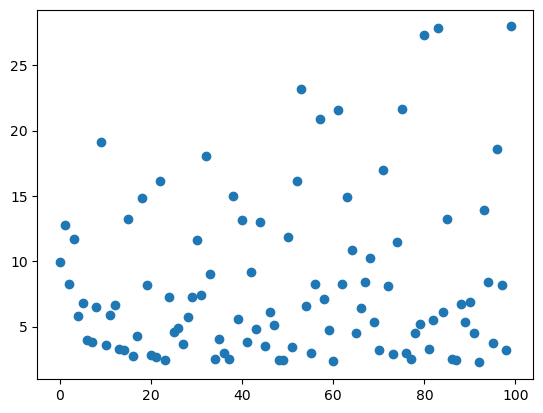

In [20]:
vel = envDict['fatigue']['windSpeed'].values
x_d = 9.6
redVel = calcJensenWakeVel(vel, x_d, turbDia, constWindDf, k = 0.04, rhoAir = 1.225)

plt.plot(redVel, 'o', label='Calculated')
plt.plot(envDict['9.6D_deficit']['windSpeed'].values, 'x', label='Ericka/Used in sims')
plt.grid(True)
plt.xlabel('Bin')
plt.ylabel('Reduced Wind Speed [m/s]')
plt.legend()

Text(0, 0.5, 'Wake Loss [%]')

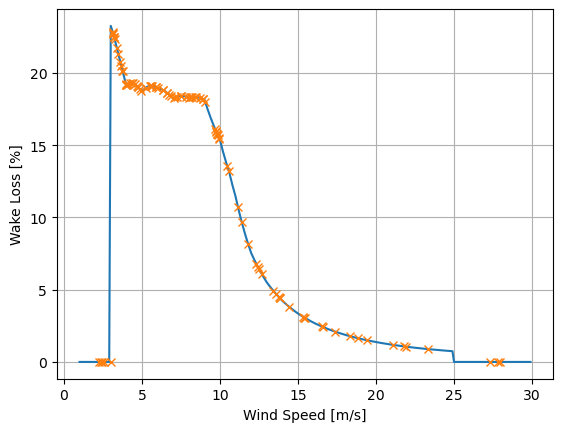

In [ ]:
vel = np.arange(1, 30, 0.1)
x_d = 9.6
redVel = calcJensenWakeVel(vel, x_d, constWindDf, k = 0.04)
plt.plot(vel, (vel - redVel)/vel*100)


vel = envDict['fatigue']['windSpeed'].values
x_d = 9.6
redVel = calcJensenWakeVel(vel, x_d, constWindDf, k = 0.04)
plt.plot(vel, (vel - redVel)/vel*100, 'x')
plt.grid(True)
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Wake Loss [%]')


## TI model

Text(0, 0.5, 'Turbulence Intensity')

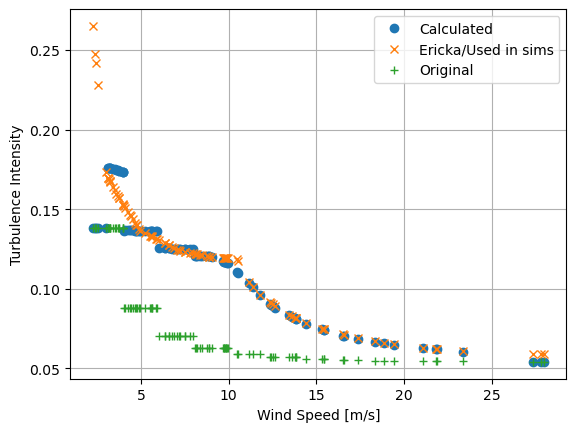

In [ ]:
df_default =  envDict['fatigue'].sort_values(by='windSpeed')
df_ericka = envDict['9.6D_deficit'].sort_values(by='windSpeed')


vel = df_default['windSpeed'].values
I0 = df_default['TI'].values
x_d = 9.6

# redVel = calcJensenWakeVel(vel, x_d, turbDia, constWindDf, k = 0.04, rhoAir = 1.225)
TI_eff= calcFrandsenTI(I0 , vel, x_d, turbDia, constWindDf, rhoAir = 1.225)

plt.plot(df_default['windSpeed'], TI_eff, 'o', label='Calculated')
plt.plot(df_default['windSpeed'], df_ericka['TI'].values, 'x', label='Ericka/Used in sims')
plt.plot(df_default['windSpeed'], df_default['TI'].values, '+', label='Original')

# plt.axvline(3, 0, color='k', linestyle='--')

plt.legend()

plt.grid(True)
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Turbulence Intensity')

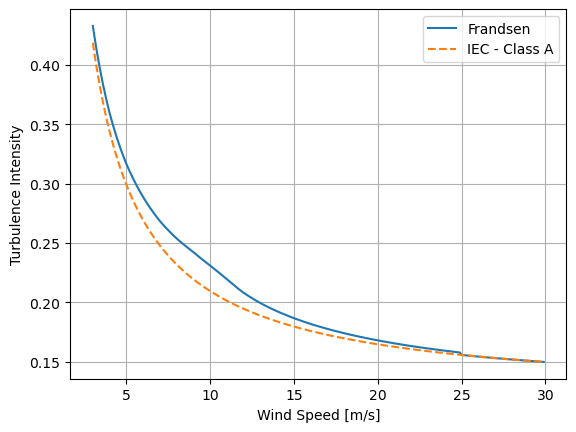

In [ ]:
vel = np.arange(3, 30, 0.1)
iec_turb = 0.16* (0.75* vel + 5.6)/vel
x_d = 9.6
turbDia = 240

TI_frandsen= calcFrandsenTI(iec_turb , vel, x_d, turbDia, constWindDf, rhoAir = 1.225)

plt.plot(vel, TI_frandsen, label='Frandsen')
plt.plot(vel, iec_turb, '--', label='IEC - Class A')

plt.grid()
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Turbulence Intensity')
plt.legend()


## Generate the new fatigue bins

In [ ]:
writeFlag = False

if writeFlag == True:

    #default fatigue bins
    envCond_df = envDict['fatigue']
    envCond_df.to_excel(os.path.join(dataFol, r"envCond_fat_default.xlsx"), index=False)


    #increaed TI
    increasedTI_df = envDict['fatigue'].copy()
    vel = increasedTI_df ['windSpeed'].values
    I0 = increasedTI_df ['TI'].values
    increasedTI_df['TI'] = calcFrandsenTI(I0 , vel, x_d, turbDia, constWindDf, rhoAir = rhoAir)
    increasedTI_df.to_excel(os.path.join(dataFol, r"envCond_fat_increasedTI.xlsx"), index=False)

    #increaed TI and reduced wind speed
    increasedTI_redVel_df = increasedTI_df.copy() #the turbulence intensity has alared been increased
    vel = increasedTI_redVel_df['windSpeed'].values
    increasedTI_redVel_df['windSpeed']  = calcJensenWakeVel(vel, x_d, turbDia, constWindDf, k = 0.04)
    increasedTI_redVel_df.to_excel(os.path.join(dataFol, r"envCond_fat_increasedTI_redVel.xlsx"), index=False)


# Simulations verification

## Mean thrust comparison against constant wind

In [ ]:
key = 'C142_0'
filePath = fat_damageDict[key]

sumDf_fat = pd.read_parquet(filePath.replace('_damage.parquet', '.parquet'))

In [ ]:
qty = ['Wind1VelX', 'Wind1VelY', 'Wind1VelZ', 'RtFldFxh', 'RtFldFyh', 'RtFldFzh', 'RtFldMxh', 'RtFldMyh', 'RtFldMzh']
meanPd    = sumDf_fat.xs('mean', axis = 1, level = 1).loc[:, qty].copy()
meanPd['windVel'] = np.sqrt(meanPd['Wind1VelX']**2 + meanPd['Wind1VelY']**2 + meanPd['Wind1VelZ']**2)
meanPd = meanPd.sort_values(by='windVel')

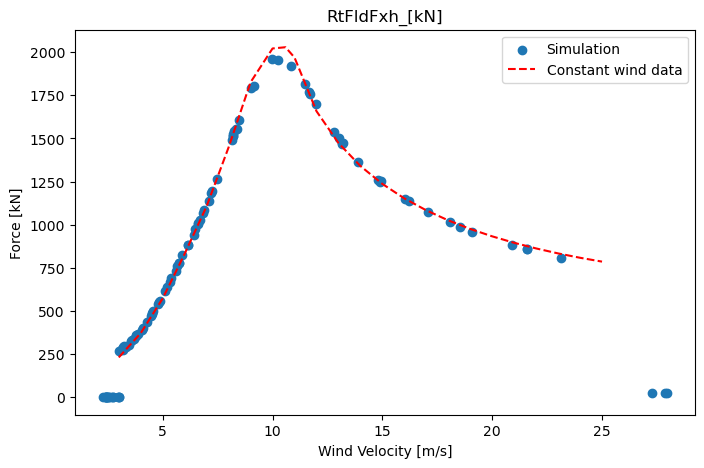

In [ ]:
fig,axs = plt.subplots(1, 1 , figsize=(8, 5))
axs.scatter(meanPd['windVel'], meanPd['RtFldFxh']/1000, label='Simulation')
axs.plot(constWindDf['Wind1VelX_[m/s]'], constWindDf['RtFldFxh_[kN]'], 'r--', label='Constant wind data')
axs.set_xlabel('Wind Velocity [m/s]')
axs.set_ylabel('Force [kN]')
axs.set_title('RtFldFxh_[kN]')
axs.legend()


## Check if the orientation is correct

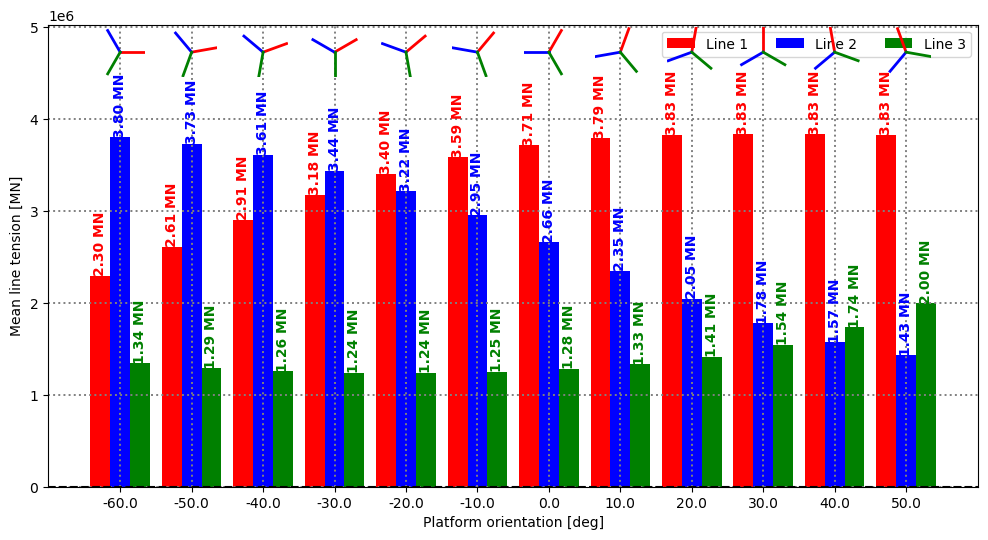

In [8]:
selBin = 1 #select bin in near rated condition which will be plotted across all orientation - also bin one comes from near north 

#plot for different orientations groped by the 3 lines

fig, ax = plt.subplots(1,1, figsize=(12, 6))

barWidth = 1/3/1.2

colorList = ['red', 'blue', 'green'] # color to identify the line names

orientList = []

for orientIndex, (key, filePath) in enumerate(fat_simDict.items()): #loop over orientations

    resPd = pd.read_parquet(filePath) #read the simulation results

    orientAngle = float(key.split('_')[1])

    orientList.append(orientAngle) #get the orientation from the key

    for lineId in range(3):

        if orientIndex == 0:
            label = f'Line {lineId + 1}'
        else:
            label = ''

        lFilter = [key for key, item in LineMap.items() if f'Line {lineId + 1} : Top Chain - Top' in item] #names of the points in that line 

        filtered_resPd = resPd.loc[resPd.index.str.contains(f'_{selBin}_')]  # Filter rows based on selBin
        damMax = filtered_resPd.xs('mean', axis=1, level=1).loc[:, lFilter].values[0, 0]  # Extract relevant columns
     
        ax.bar(orientIndex - barWidth + lineId * barWidth, damMax, label = label, width = barWidth, color = colorList[lineId])

        #add a label on top
        ax.text(orientIndex - barWidth + lineId * barWidth, damMax + 0.0025, f'{damMax/1e6:.2f} MN', ha='center', rotation = 90, va='bottom', fontsize=10, color = colorList[lineId], fontweight='bold')



    #------- orientation wise plot
    # === Add inset plot to show orientation === #
    inset_size = 0.5
    ax_inset = inset_axes(ax, width=inset_size, height=inset_size, loc='upper center',
                          bbox_to_anchor=(orientIndex, 5e6),
                          bbox_transform=ax.transData, 
                          borderpad=0)

    ax_inset.set_xlim(-1, 1)
    ax_inset.set_ylim(-1, 1)
    ax_inset.axis('off')

    angles = [orientAngle + offset for offset in [60, 180, -60]]  # Line 1, 2, 3
    for a, c in zip(angles, colorList):
        x = [0, np.cos(np.radians(a))]
        y = [0, np.sin(np.radians(a))]
        ax_inset.plot(x, y, color=c, lw=2)



plt.sca(ax)
yLims = plt.ylim()
plt.ylim(yLims[0], yLims[1] + 1e6)


plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# # plt.legend().remove()
plt.ylabel('Mean line tension [MN]')
plt.xlabel('Platform orientation [deg]')

plt.axhline(y =0.33, color='k', linestyle='--')
yLims = plt.ylim() 
ax.set_ylim(yLims[0], yLims[1] + 0.05)
ax.set_xticks(range(len(orientList)))
ax.set_xticklabels(orientList, rotation=0)
ax.legend(ncol = 3)

# plt.text(2, 0.335, '0.33', fontstyle='italic', color='k', weight='bold', )       

        

## Compare mean tensions from dynamic simulations and value used for stiffness calculation

In [10]:
tenCompDict = {}

for key, filePath in fat_damageDict.items():

    try :

        sumDf_fat = pd.read_parquet(filePath.replace('_damage.parquet', '.parquet'))
        valHeader = [col[0] for col in sumDf_fat.columns if col[1] == 'mean' and ('FAIR' in col[0] or 'ANCH' in col[0]) and ('HORZ' not in col[0])]
        valType   = 'mean'
        meanPd    = sumDf_fat.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy()
        # meanPd['Run_P200_C142_L1430_clump40_9_S1.outb', :]
        # meanPd = meanPd.drop('Run_P200_C142_L1430_clump40_1_S1.outb')

        moorpyTenPd = pd.read_parquet(filePath.replace('_damage.parquet', '_meanLineTensions.parquet'))
        moorpyTenPd.index = moorpyTenPd.index + '.outb'
        moorpyTenPd = moorpyTenPd.loc[meanPd.index, valHeader]
        # moorpyTenPd.index = moorpyTenPd.index.str.replace('Run_P200','Run_P200')

        diff = (meanPd  - moorpyTenPd)/moorpyTenPd*100

        tenCompDict[key] = {'maxDiff': diff.abs().max().max(), 'maxDiffLoc': diff.abs().idxmax().max()}

        # flatDiff = diff.abs().stack()  # flatten to (index, column) MultiIndex
        # top4 = flatDiff.nlargest(4)

        # tenCompDict[key] = {
        #     'topDiffs(%)': top4.values,
        #     'locations': list(top4.index)
        # }

    except :
        # pass
        print(f'Probably file does not exist for {key}. Skipping')

display(pd.DataFrame(tenCompDict).T)  


,maxDiff,maxDiffLoc
C142_-60,0.152866,Run_P200_C142_L1430_clump40_86_S1.outb
C142_-50,0.092644,Run_P200_C142_L1430_clump40_73_S1.outb
C142_-40,0.114624,Run_P200_C142_L1430_clump40_94_S1.outb
C142_-30,0.121266,Run_P200_C142_L1430_clump40_73_S1.outb
C142_-20,0.144365,Run_P200_C142_L1430_clump40_94_S1.outb
C142_-10,0.130391,Run_P200_C142_L1430_clump40_94_S1.outb
C142_0,0.154145,Run_P200_C142_L1430_clump40_95_S1.outb
C142_10,0.129278,Run_P200_C142_L1430_clump40_86_S1.outb
C142_20,0.110808,Run_P200_C142_L1430_clump40_94_S1.outb
C142_30,0.117544,Run_P200_C142_L1430_clump40_73_S1.outb


# Damage against orientation

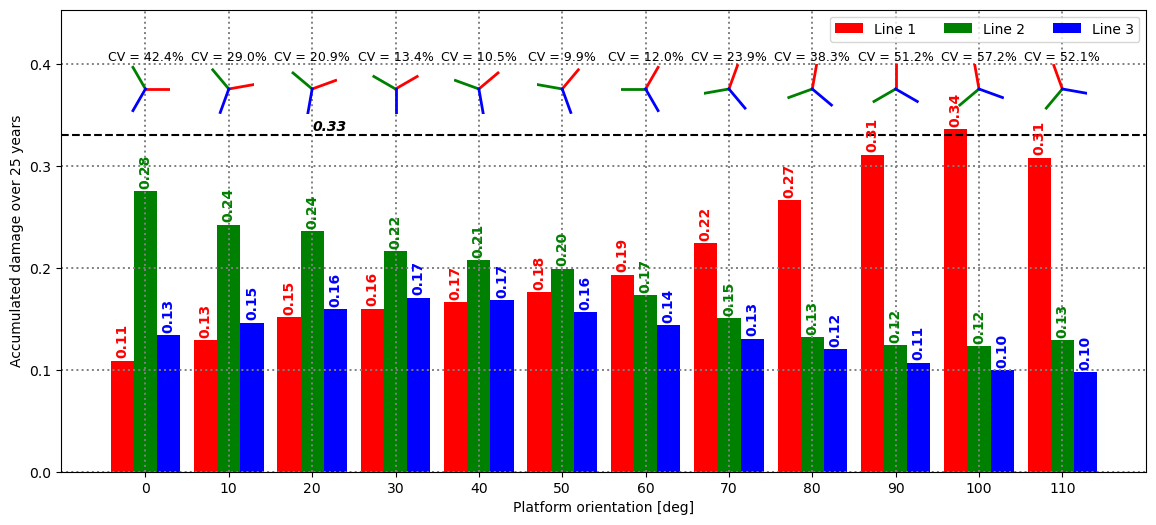

In [24]:
#plot for different orientations groped by the 3 lines

fig, ax = plt.subplots(1,1, figsize=(14, 6))


barWidth = 1/3/1.2

colorList = ['red', 'green', 'blue'] # color to identify the line names

orientList = []

for orientIndex, (key, filePath) in enumerate(fat_damageDict.items()): #loop over orientations

    damDict = calcDamage(filePath, fatBinDf)

    orientAngle = float(key.split('_')[1])

    orientList.append(orientAngle) #get the orientation from the key

    dMaxList = []

    for lineId in range(3):

        if orientIndex == 0:
            label = f'Line {lineId + 1}'
        else:
            label = ''

        lFilter = [key for key, item in LineMap.items() if f'Line {lineId + 1}' in item] #names of the points in that line 

        

        # filtered_resPd = resPd.loc[resPd.index.str.contains(f'_{selBin}_')]  # Filter rows based on selBin    

        damMax = np.max(np.array([item for key, item in damDict.items() if key in lFilter]))#worst case for that line among all the points on that line
        dMaxList.append(damMax)

        ax.bar(orientIndex - barWidth + lineId * barWidth, damMax, label = label, width = barWidth, color = colorList[lineId])

        #add a label on top
        ax.text(orientIndex - barWidth + lineId * barWidth, damMax + 0.0025, f'{damMax:.2f}', ha='center', rotation = 90, va='bottom', fontsize=10, color = colorList[lineId], fontweight='bold')

    cov = np.std(dMaxList)/np.mean(dMaxList) * 100
    ax.text(orientIndex, 0.4, f'CV = {cov:.1f}%', ha='center', rotation = 0, va='bottom', fontsize=9, color = 'k')


    #------- orientation wise plot
        # === Add inset plot to show orientation === #
    inset_size = 0.5
    ax_inset = inset_axes(ax, width=inset_size, height=inset_size, loc='upper center',
                          bbox_to_anchor=(orientIndex, 0.4),
                          bbox_transform=ax.transData, 
                          borderpad=0)

    ax_inset.set_xlim(-1, 1)
    ax_inset.set_ylim(-1, 1)
    ax_inset.axis('off')

    angles = [orientAngle + offset for offset in [60, 180, -60]]  # Line 1, 2, 3
    for a, c in zip(angles, colorList):
        x = [0, np.cos(np.radians(a))]
        y = [0, np.sin(np.radians(a))]
        ax_inset.plot(x, y, color=c, lw=2)



plt.sca(ax)
yLims = plt.ylim()
plt.ylim(yLims[0], yLims[1] + 0.05)

# plt.title(f'Accumulated damage over 25 years')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# # plt.legend().remove()
plt.ylabel('Accumulated damage over 25 years')
plt.xlabel(r'Platform orientation [deg]')

plt.axhline(y =0.33, color='k', linestyle='--')
yLims = plt.ylim() 
ax.set_ylim(yLims[0], yLims[1] + 0.05)
ax.set_xticks(range(len(orientList)))
ax.set_xticklabels(orientList, rotation=0)
ax.set_xticklabels(np.arange(0,120, 10), rotation=0)
ax.legend(ncol = 3)

plt.text(2, 0.335, '0.33', fontstyle='italic', color='k', weight='bold') 

fig.savefig(os.path.join('damage_orientation.png'), dpi=300, bbox_inches='tight')
        

# Damage sensitivity to wake effects

In [12]:
damCases =   {
                'C1' : os.path.join(resultsFol, "P200_C142_L1430_clump40_fat_-50_default_damage.parquet"),
                'C2' : os.path.join(resultsFol, "P200_C142_L1430_clump40_fat_-50_increasedTI_damage.parquet"),
                'C3' : os.path.join(resultsFol, "P200_C142_L1430_clump40_fat_-50_damage.parquet"), 
            }    

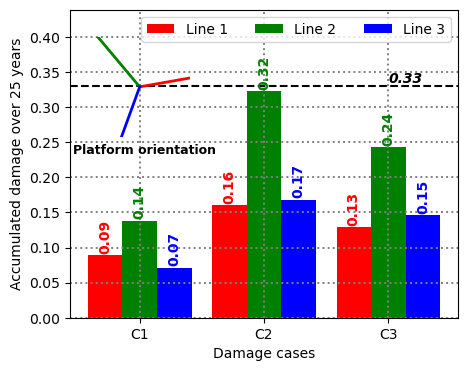

In [13]:
#plot for different orientations groped by the 3 lines

fig, ax = plt.subplots(1,1, figsize=(5, 4))

barWidth = 1/3/1.2


colorList = ['red', 'green', 'blue'] # color to identify the line names

orientList = []

for orientIndex, (key, filePath) in enumerate(damCases.items()): #loop over orientations

    damDict = calcDamage(filePath, fatBinDf)

    orientAngle = key
    orientList.append(orientAngle) #get the orientation from the key

    dMaxList = []

    for lineId in range(3):

        if orientIndex == 0:
            label = f'Line {lineId + 1}'
        else:
            label = ''

        lFilter = [key for key, item in LineMap.items() if f'Line {lineId + 1}' in item] #names of the points in that line 

        

        # filtered_resPd = resPd.loc[resPd.index.str.contains(f'_{selBin}_')]  # Filter rows based on selBin    

        damMax = np.max(np.array([item for key, item in damDict.items() if key in lFilter]))#worst case for that line among all the points on that line
        dMaxList.append(damMax)

        ax.bar(orientIndex - barWidth + lineId * barWidth, damMax, label = label, width = barWidth, color = colorList[lineId])

        #add a label on top
        ax.text(orientIndex - barWidth + lineId * barWidth, damMax + 0.0025, f'{damMax:.2f}', ha='center', rotation = 90, va='bottom', fontsize=10, color = colorList[lineId], fontweight='bold')


#platform orienation
inset_size = 1
ax_inset = inset_axes(ax, width=inset_size, height=inset_size, loc='upper center',
                        bbox_to_anchor=(0, 0.4),
                        bbox_transform=ax.transData, 
                        borderpad=0)

ax_inset.set_xlim(-1, 1)
ax_inset.set_ylim(-1, 1)
ax_inset.axis('off')

angles = [-50 + offset for offset in [60, 180, -60]]  # Line 1, 2, 3
for a, c in zip(angles, colorList):
    x = [0, 5*np.cos(np.radians(a))]
    y = [0, 5*np.sin(np.radians(a))]
    ax_inset.plot(x, y, color=c, lw=2)
ax_inset.text(0.1, -1.4, 'Platform orientation', ha='center', rotation = 0, va='bottom', fontsize=9, color = 'k', fontweight='bold')

plt.sca(ax)
yLims = plt.ylim()
plt.ylim(yLims[0], yLims[1] + 0.05)

# plt.title(f'Accumulated damage over 25 years')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# # plt.legend().remove()
plt.ylabel('Accumulated damage over 25 years')
plt.xlabel('Damage cases')

plt.axhline(y =0.33, color='k', linestyle='--')
yLims = plt.ylim() 
ax.set_ylim(yLims[0], yLims[1] + 0.05)
ax.set_xticks(range(len(orientList)))
ax.set_xticklabels(orientList, rotation=0)
ax.legend(ncol = 3)

plt.text(2, 0.335, '0.33', fontstyle='italic', color='k', weight='bold') 

fig.savefig(os.path.join('damage_Sensitivity.png'), dpi=300, bbox_inches='tight')
        

IndexError: list index out of range

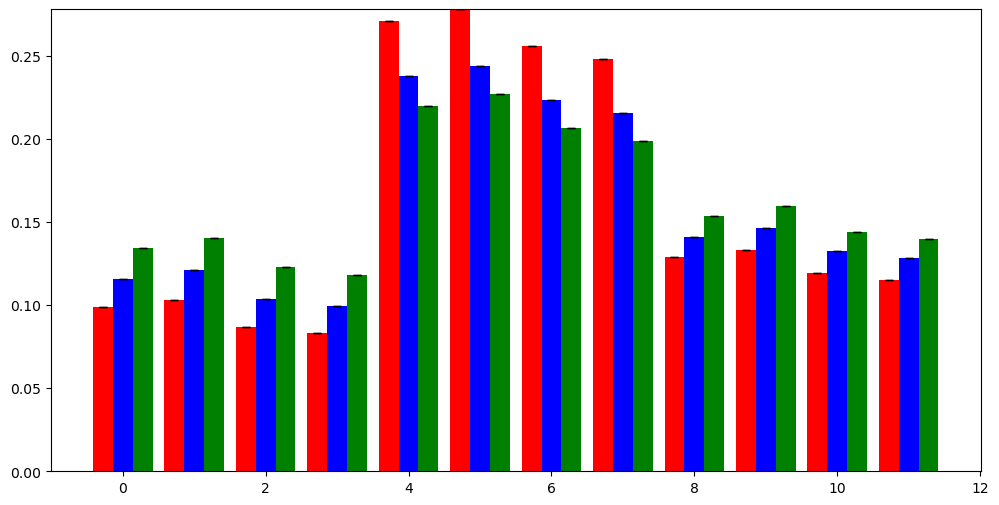

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(12, 6))


barWidth = 1/3/1.2

colorList = ['red', 'blue', 'green']


for typeIndex, key in enumerate(damCaseDict.keys()):

    damRenameDf = damCaseDict[key].copy()
    damRenameDf = damRenameDf.loc[LineMap.keys(), :]
    damRenameDf = damRenameDf.rename(index = LineMap)

    for barIndex, (ind, row) in enumerate(damRenameDf.iterrows()):
        if barIndex == 0:
            label = 'platHead = ' +  key.split('_')[1] + ' deg'
        else:
            label = ''

        ax.bar(barIndex - barWidth + typeIndex * barWidth, row['mean'], yerr = row['std'], capsize=barWidth*10, label = label, width = barWidth, color = colorList[typeIndex])
        ax.bar(barIndex - barWidth + typeIndex * barWidth, row['max'] - row['min'], bottom = row['min'], width = barWidth/1.7, color = 'grey', alpha = 0.8)


        if barIndex == len(damRenameDf)-1 and typeIndex == len(damCaseDict)-1:
        
            ax.annotate('Mean', xy=(barIndex - barWidth + typeIndex * barWidth,  row['mean']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['mean']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Std.dev', xy=(barIndex - barWidth + typeIndex * barWidth,  row['mean']+row['std']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['mean']+row['std']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Min', xy=(barIndex - barWidth + typeIndex * barWidth,  row['min']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['min']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Max', xy=(barIndex - barWidth + typeIndex * barWidth,  row['max']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['max']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')



# ax.set_xticks(range(len(damRenameDf.index)))



plt.title(f'Accumulated damage over 25 years')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# # plt.legend().remove()
plt.ylabel('Damage')
plt.xlabel('Lines')

plt.axhline(y =0.33, color='k', linestyle='--')
xLims = plt.xlim() 
ax.set_xlim(xLims[0], xLims[1] + 0.5)
ax.set_xticks(range(len(damRenameDf.index)))
ax.set_xticklabels(damRenameDf.index, rotation=45, ha='right')
ax.legend()

plt.text(xLims[1] -3, 0.335, '0.33', fontstyle='italic', color='k', weight='bold', )

### Simplified version of the above plot

In [ ]:
damCaseDict.keys()

dict_keys(['C135_0', 'C135_10', 'C135_-50'])

Text(9.008333333333333, 0.335, '0.33')

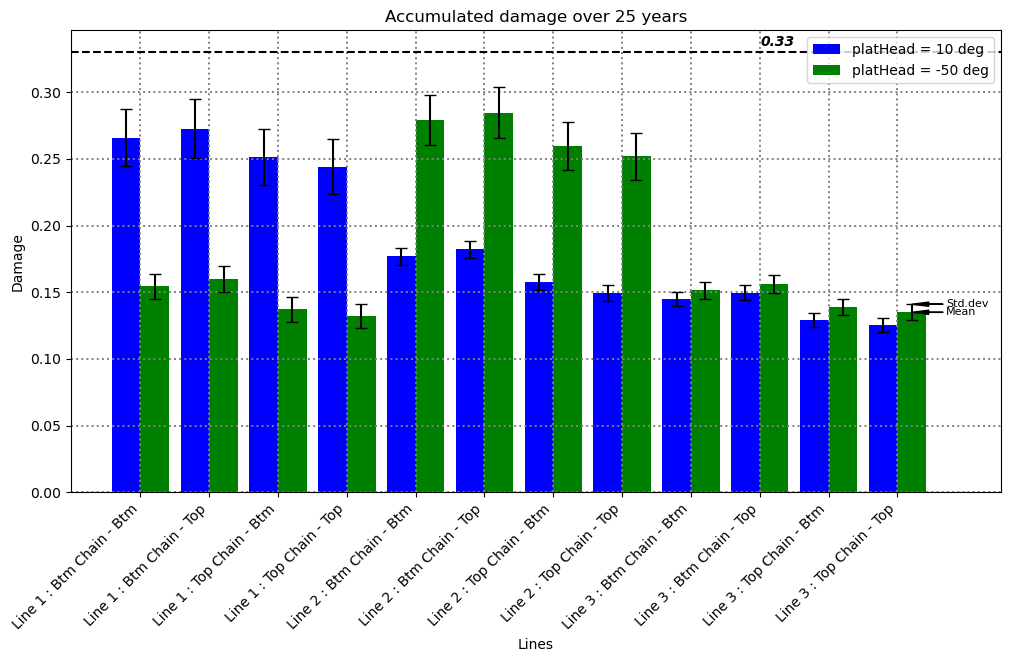

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(12, 6))


barWidth = 1/2/1.2

colorList = [ 'blue', 'green']


for typeIndex, key in enumerate(list(damCaseDict.keys())[1:]):

    damRenameDf = damCaseDict[key].copy()
    damRenameDf = damRenameDf.loc[LineMap.keys(), :]
    damRenameDf = damRenameDf.rename(index = LineMap)

    for barIndex, (ind, row) in enumerate(damRenameDf.iterrows()):
        if barIndex == 0:
            label = 'platHead = ' +  key.split('_')[1] + ' deg'
        else:
            label = ''

        ax.bar(barIndex - barWidth/2 + typeIndex * barWidth, row['mean'], yerr = row['std'], capsize=barWidth*10, label = label, width = barWidth, color = colorList[typeIndex])
        # ax.bar(barIndex - barWidth/2 + typeIndex * barWidth, row['max'] - row['min'], bottom = row['min'], width = barWidth/1.7, color = 'grey', alpha = 0.8)


        if barIndex == len(damRenameDf)-1 and typeIndex == len(damCaseDict)-2:
        
            ax.annotate('Mean', xy=(barIndex - barWidth/2 + typeIndex * barWidth,  row['mean']), xytext=(barIndex - barWidth/2 + typeIndex * barWidth + 0.5, row['mean']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Std.dev', xy=(barIndex - barWidth/2 + typeIndex * barWidth,  row['mean']+row['std']), xytext=(barIndex - barWidth/2 + typeIndex * barWidth + 0.5, row['mean']+row['std']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            # ax.annotate('Min', xy=(barIndex - barWidth + typeIndex * barWidth,  row['min']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['min']), size=8,
            #                 arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            # ax.annotate('Max', xy=(barIndex - barWidth + typeIndex * barWidth,  row['max']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['max']), size=8,
            #                 arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')



# ax.set_xticks(range(len(damRenameDf.index)))



plt.title(f'Accumulated damage over 25 years')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# # plt.legend().remove()
plt.ylabel('Damage')
plt.xlabel('Lines')

plt.axhline(y =0.33, color='k', linestyle='--')
xLims = plt.xlim() 
ax.set_xlim(xLims[0], xLims[1] + 0.5)
ax.set_xticks(range(len(damRenameDf.index)))
ax.set_xticklabels(damRenameDf.index, rotation=45, ha='right')
ax.legend(loc = 'upper right')

plt.text(xLims[1] -3, 0.335, '0.33', fontstyle='italic', color='k', weight='bold', )

## Convergence checks

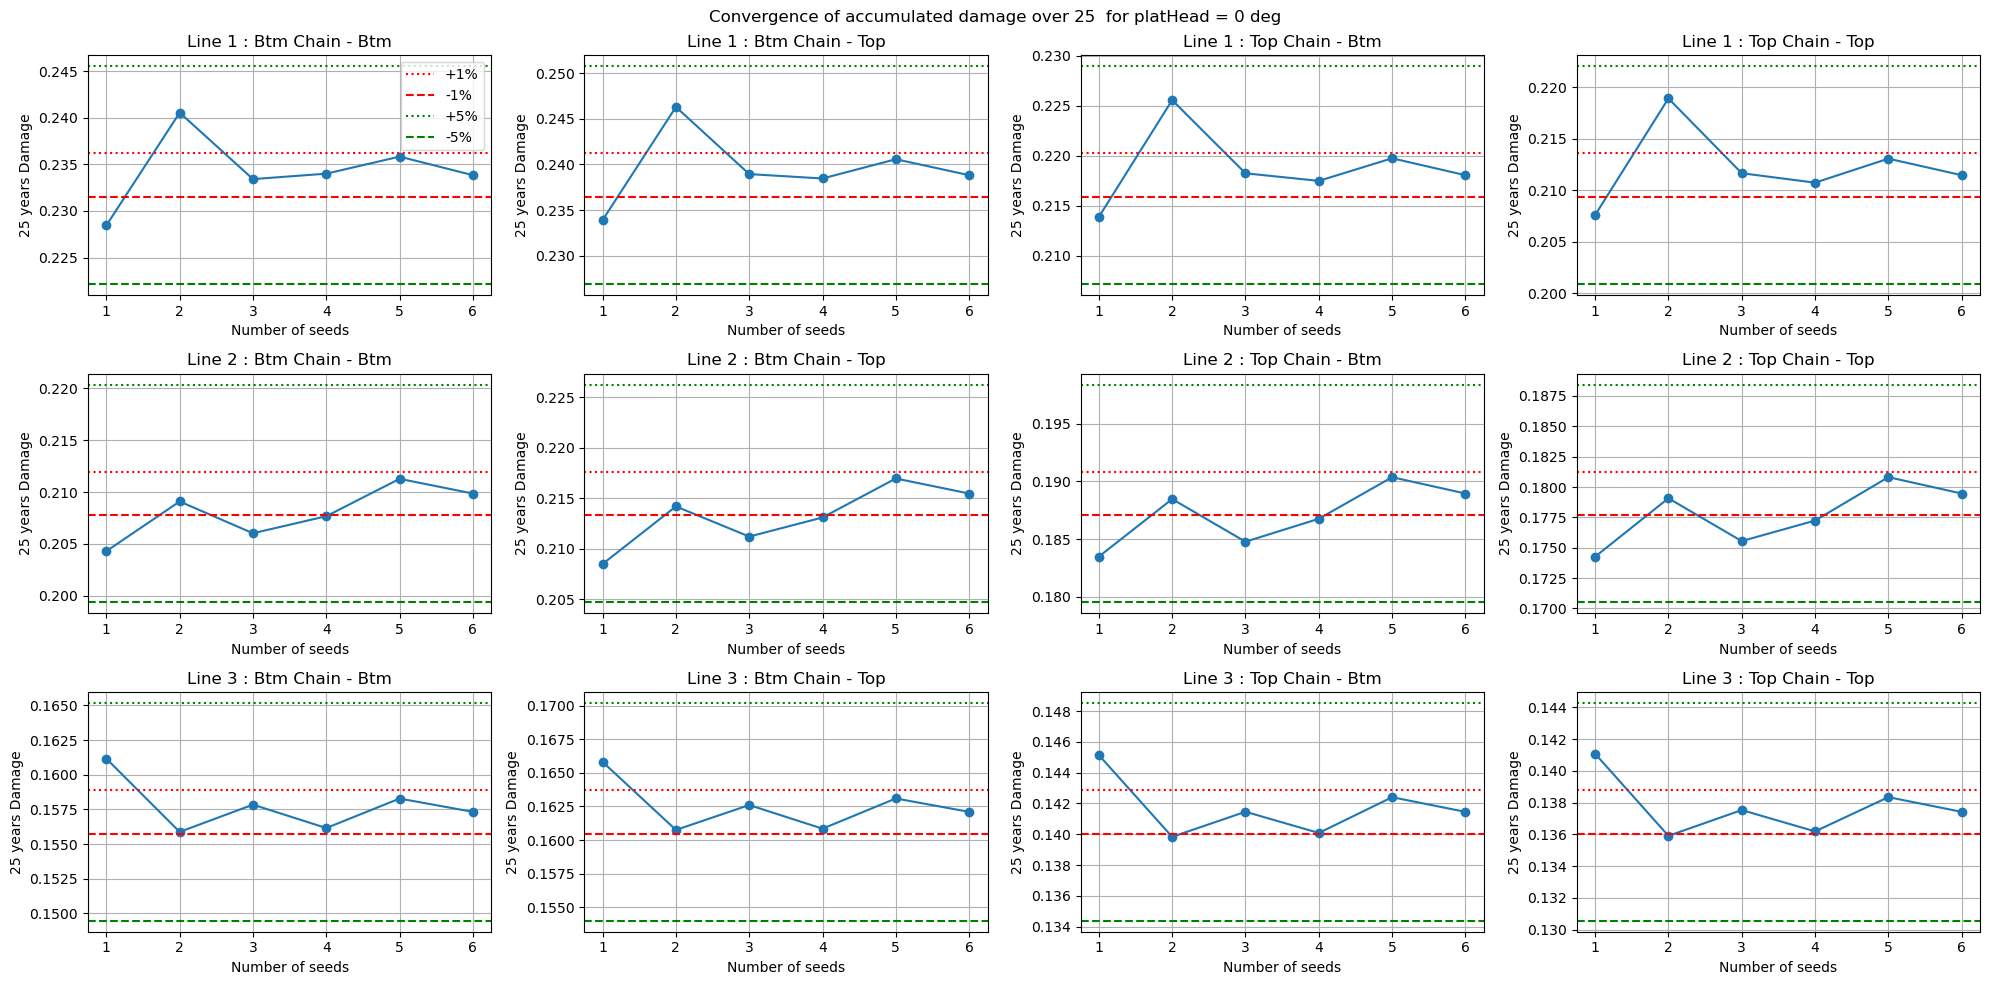

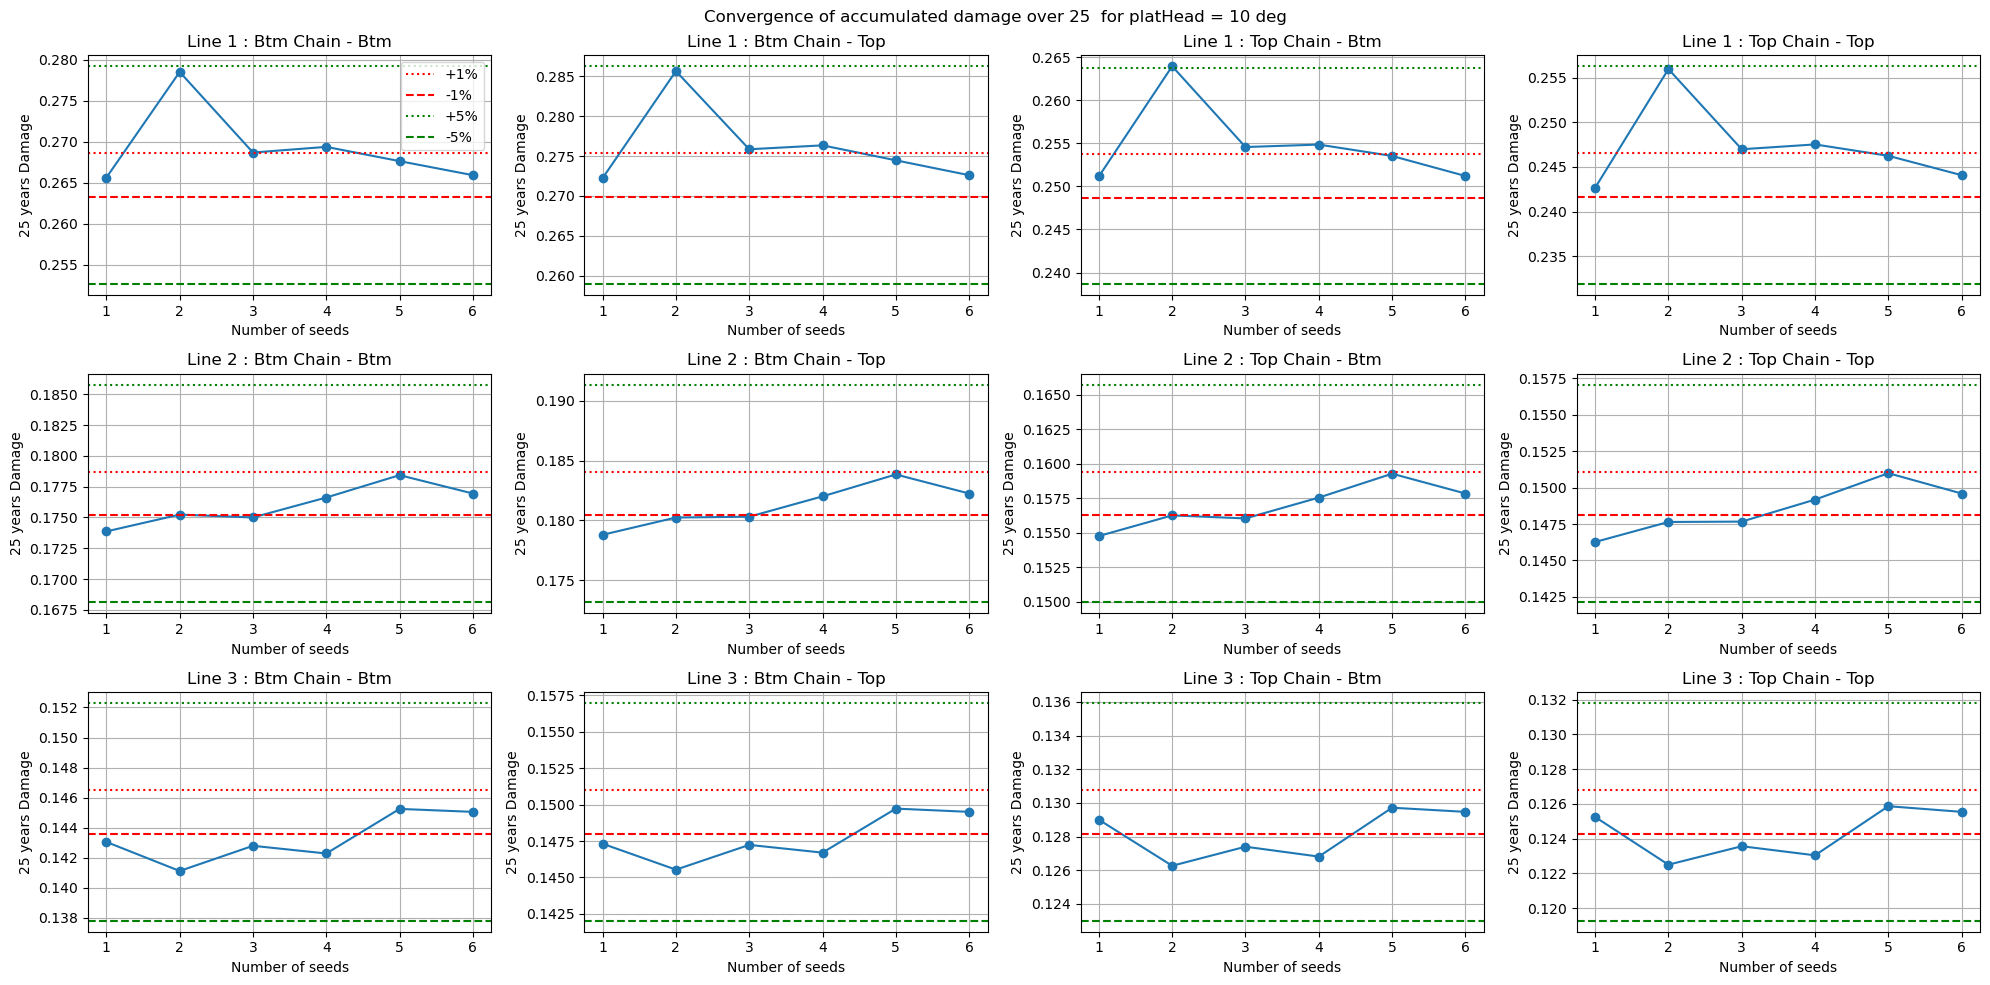

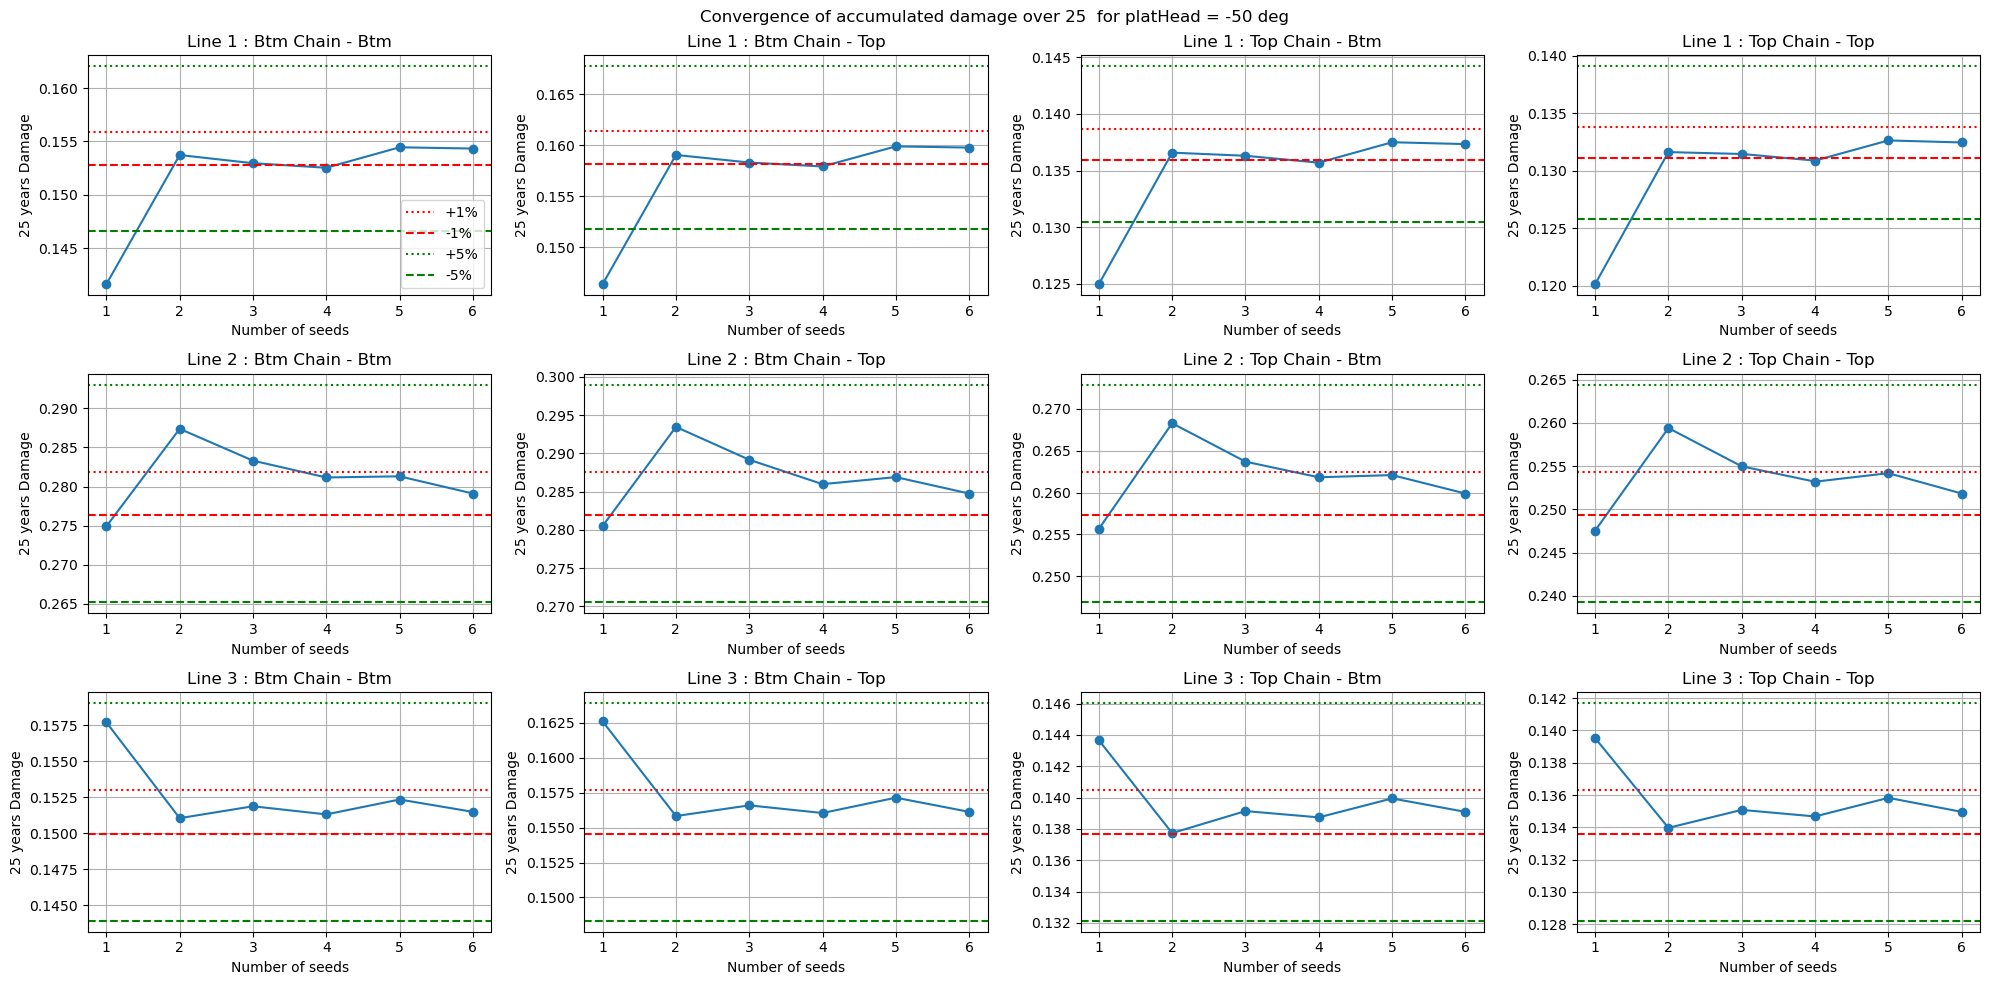

In [ ]:
for key, df_path in fat_damageDict.items():

    df = pd.read_parquet(df_path)

    df = df.reset_index()
    df['bin'] = df['index'].str.extract(r'.*_(\d+)_.*').astype(int)
    df['seed'] = df['index'].str.extract(r'.*_S(\d+).*').astype(int)
    df.set_index('index', inplace=True)
    seedList = df['seed'].unique()


    convDict = {}

    for ind in range(1,len(seedList)+1):
        
        seeds = seedList[:ind]
        
        df_mean = df[df['seed'].isin(seeds)].groupby('bin').mean()

        damDict_mean = getDamDict(df_mean, fatBinDf)
        
        convDict[ind] = damDict_mean


    convDf = pd.DataFrame(convDict).T


    fig, axs = plt.subplots(3,4, figsize=(20, 10))

    fig.suptitle(f'Convergence of accumulated damage over 25  for {'platHead = ' +  key.split('_')[1] + ' deg'}')

    convDf = convDf[LineMap.keys()]

    for ind, (ax, col) in enumerate(zip(axs.flatten(), convDf.columns)):
        ax.plot(convDf.index, convDf[col], '-o')
        ax.axhline(y = convDf[col].values[-1]*1.01, color='r', linestyle=':', label = '+1%')
        ax.axhline(y = convDf[col].values[-1]*0.99, color='r', linestyle='--', label = '-1%')

        ax.axhline(y = convDf[col].values[-1]*1.05, color='g', linestyle=':', label = '+5%')
        ax.axhline(y = convDf[col].values[-1]*0.95, color='g', linestyle='--', label = '-5%')

        ax.set_title(LineMap[col])
        ax.grid()
        ax.set_xlabel('Number of seeds')
        ax.set_ylabel('25 years Damage')
        if ind == 0:
            ax.legend()
        ax.set_xticks(range(1, max(convDf.index)+1))
    plt.tight_layout()
